# Example for point source parameter estimation with SWYFT

In [ ]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
NDIM = 5 # number of parameters

In [3]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    X, Y = np.mgrid[-5:5:50j, -5:5:50j]
    
    # parameters z[0] ... z[2] determine diffuse bkg
    iso = z[0] * np.ones_like(X)
    scale = z[2] + 0.1
    disk = 10 * z[1] * np.exp(-X**2/scale**2/2)
    diff = disk + iso
    
    # N point sources
    N = int(z[4] * 10000)
    # spatial distribution uniform
    i, j = np.random.choice(50, (2, N))  # just indices
    # log normal distribution for fluxes, depends on z[3]
    f = 10**(np.random.randn(N)*0.5) * z[3]
    
    # point source map
    psc = np.zeros_like(X)
    psc[i, j] += f
    
    # Gamma-ray sky
    sky = psc + diff
    
    # simple detection threshold model
    # at least 5 sigma, maybe harder in disk
    threshold = diff*z[5] + 5*sigma
    det = psc > threshold
    
    return np.array([det, sky])

In [4]:
def noisemodel(x, z, sigma = 0.1):
    x = x.copy()
    x[1] = x[1] + np.random.randn(*x[1].shape)*sigma
    return x

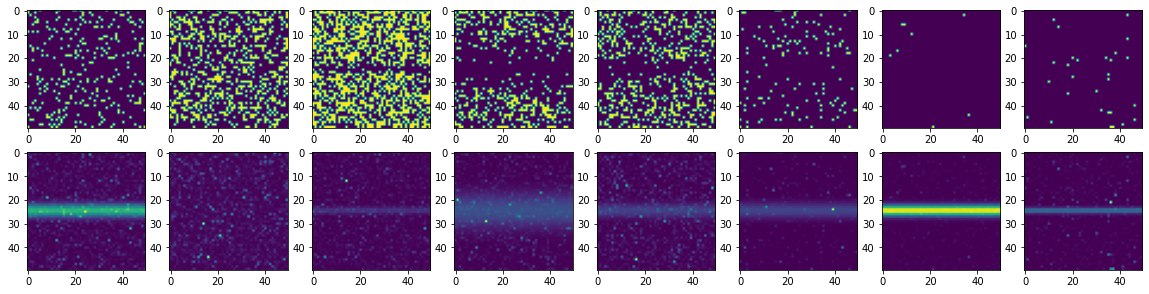

In [5]:
# Random image realizations, without noise

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(4, 8, i+1)
    z = np.random.rand(6)
    #z0 = np.array([0.1, 0.2, 0.1, 0.4, 1.0, 0.5])
    x = model(z)
    plt.imshow(x[0])
    plt.subplot(4, 8, i+1 + 8)
    plt.imshow(x[1])

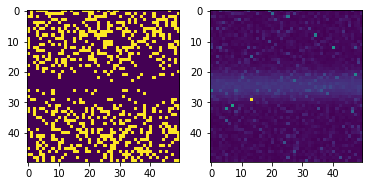

In [6]:
z0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
x0 = noisemodel(model(z0), z0)
plt.subplot(121)
plt.imshow(x0[0])
plt.subplot(122)
plt.imshow(x0[1])

In [7]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv0a = torch.nn.Conv2d(2, 100, 1)
        #self.conv0b = torch.nn.Conv2d(100, 1, 1)
        self.conv1 = torch.nn.Conv2d(2, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        #x = x.unsqueeze(1)
        #x = self.conv0a(x)
        #x = torch.relu(x)
        #x = self.conv0b(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [8]:
# Instantiate network

ds = swyft.DataStoreZarr()
ds.init(zdim = 6, xdim = (2, 50, 50))

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [9]:
sw = swyft.SWYFT(x0, zdim = 6, device = DEVICE, head = Head, noisemodel = noisemodel, datastore = ds, nsamples = 5000)
ds.simulate(model)
sw.train1d(max_epochs = 100, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])

Simulate:   0%|          | 0/4968 [00:00<?, ?it/s]

Constrained posterior area: 1.0
Adding 4968 new samples. Run simulator!


Simulate: 100%|██████████| 4968/4968 [00:12<00:00, 412.97it/s]


Number of output features: 160
Start training
LR iteration 0
Total epochs: 3
Validation losses: [12.47084265947342, 11.333070516586304, 11.392066419124603]
LR iteration 1
Total epochs: 4
Validation losses: [10.828928709030151, 10.470061719417572, 10.368426859378815, 10.405677914619446]
LR iteration 2
Total epochs: 2
Validation losses: [10.024483740329742, 10.03593647480011]


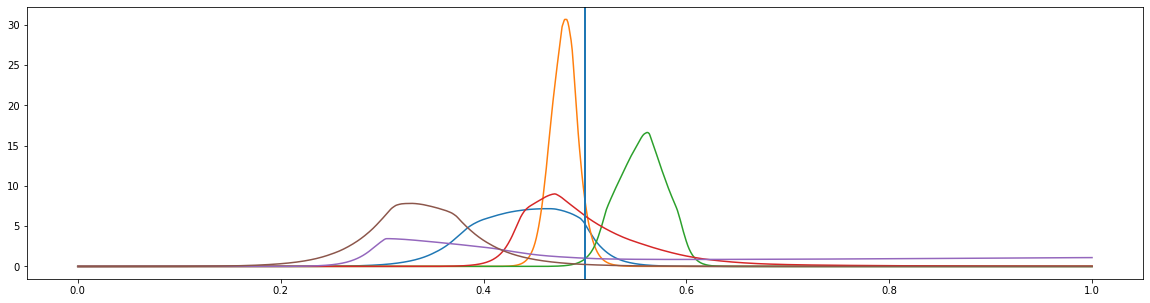

In [82]:
#z0 = np.array([0.1, 0.2, 0.3, 0.4, 1.0, 0.6])
#x0 = model(z0)

plt.figure(figsize=(20, 5))
for i in range(6):
    z, p = sw.posterior(i)
    plt.axvline(z0[i])
    plt.plot(z, p)

In [84]:
sw.trainNd([[0, 1], [1, 2], [0, 2]], max_epochs = 100, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4], tag = 'default')

Number of output features: 160
Start training
LR iteration 0
Total epochs: 4
Validation losses: [3.3477564603090286, 2.9722699746489525, 2.6728346571326256, 2.771815724670887]
LR iteration 1
Total epochs: 3
Validation losses: [2.0819213800132275, 2.0458439141511917, 2.151457581669092]
LR iteration 2
Total epochs: 4
Validation losses: [2.0404645577073097, 1.9120170958340168, 1.9012164287269115, 2.0234895274043083]


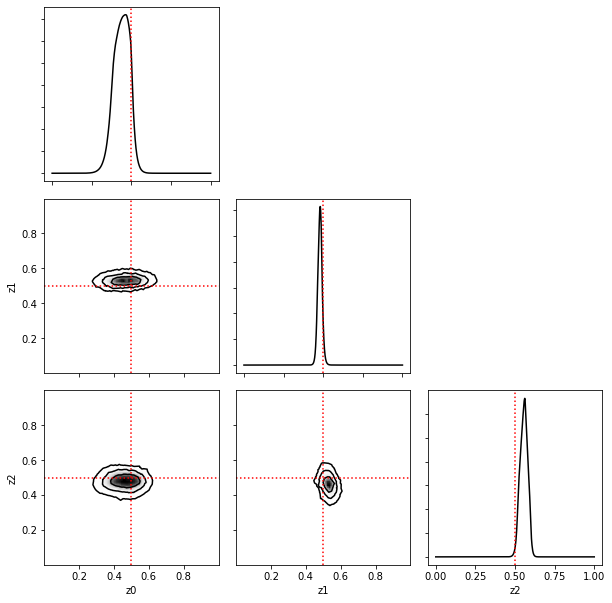

In [86]:
swyft.corner(sw, z0 = z0, tag = 'default', cmap = 'Greys', params = [0, 1, 2], dim = 10)

In [87]:
sw.trainNd([[3, 4]], max_epochs = 100, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4], tag = '2')

Number of output features: 160
Start training
LR iteration 0
Total epochs: 4
Validation losses: [1.764694258570671, 1.6248056441545486, 1.4125568121671677, 1.4370614290237427]
LR iteration 1
Total epochs: 2
Validation losses: [1.2910671159625053, 1.3757648020982742]
LR iteration 2
Total epochs: 2
Validation losses: [1.259959988296032, 1.2882136702537537]


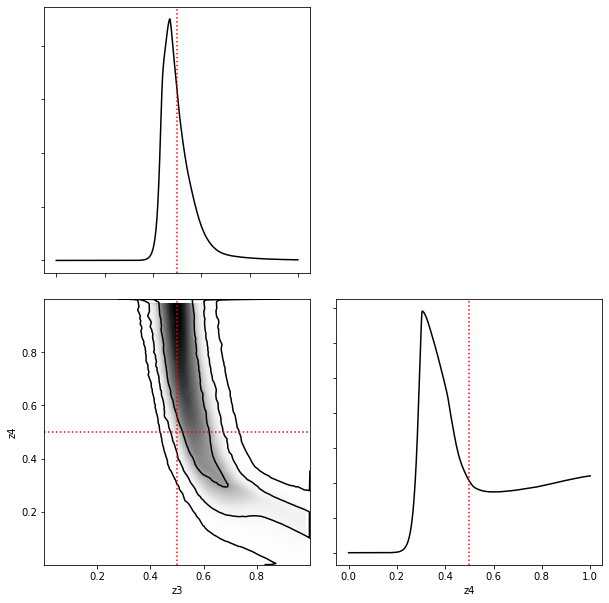

In [89]:
swyft.corner(sw, z0 = z0, tag = '2', cmap = 'Greys', params = [3,4], dim = 10)

In [ ]:
def corr